In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#install pyvi package
!pip install pyvi

In [0]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP

In [0]:
import os 

def get_data(folder_path):
    data = []
    labels = []
    dirs = os.listdir(folder_path)
    for path in tqdm(dirs):
        file_paths = os.listdir(os.path.join(folder_path, path))
        for file_path in (file_paths):
            with open(os.path.join(folder_path, path, file_path), 'r', encoding="utf-16") as f:
                lines = f.readlines()
                lines = ' '.join(lines)
                
#               Tien xu li du lieu don gian
                lines = gensim.utils.simple_preprocess(lines)
                lines = ' '.join(lines)
        
#               Tách từ tiếng Việt
                lines = ViTokenizer.tokenize(lines)
                data.append(lines)
                labels.append(path)

    return data, label

In [0]:
X_data, y_data = get_data('/content/drive/My Drive/NLP/10Topics/Ver1.1/Train_Full')

In [0]:
# import pickle

# pickle.dump(X_data, open('/content/drive/My Drive/NLP/10Topics/Ver1.1/X_data.pkl', 'wb'))
# pickle.dump(y_data, open('/content/drive/My Drive/NLP/10Topics/Ver1.1/y_data.pkl', 'wb'))

In [0]:
X_test, y_test = get_data('/content/drive/My Drive/NLP/10Topics/Ver1.1/Test_Full')


In [0]:
pickle.dump(X_test, open('/content/drive/My Drive/NLP/10Topics/Ver1.1/X_test.pkl', 'wb'))
pickle.dump(y_test, open('/content/drive/My Drive/NLP/10Topics/Ver1.1/y_test.pkl', 'wb'))

In [0]:
#word enb
import os
import pickle
X_test = pickle.load(open("/content/drive/My Drive/NLP/10Topics/Ver1.1/X_data.pkl",'rb'))
y_test = pickle.load(open("/content/drive/My Drive/NLP/10Topics/Ver1.1/y_data.pkl",'rb'))
X_data = pickle.load(open("/content/drive/My Drive/NLP/10Topics/Ver1.1/X_test.pkl",'rb'))
y_data = pickle.load(open("/content/drive/My Drive/NLP/10Topics/Ver1.1/y_test.pkl",'rb'))

In [0]:
with open('/content/drive/My Drive/NLP/vietnamese-stopwords-dash.txt', 'r') as f:
    stopwords = set([w.strip() for w in f.readlines()])

In [0]:
for i in range(len(X_data)):
    text = X_data[i]
    try:
        split_words =  [x.strip('0123456789%@$.,=+-!;/()*"&^:#|\n\t\'').lower() for x in text.split()]
    except TypeError:
        split_words =  []
    X_data[i] = ' '.join([word for word in split_words if word not in stopwords])

In [0]:
for i in range(len(X_test)):
    text = X_test[i]
    try:
        split_words =  [x.strip('0123456789%@$.,=+-!;/()*"&^:#|\n\t\'').lower() for x in text.split()]
    except TypeError:
        split_words =  []
    X_test[i] = ' '.join([word for word in split_words if word not in stopwords])

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', max_features=10000)
#Tính tfidf cho tập train
tfidf_vect.fit(X_data)
pickle.dump(tfidf_vect, open("/content/drive/My Drive/NLP/Model/vectorizer.pickle", "wb"))
tfidf_X_data =  tfidf_vect.transform(X_data)
tfidf_X_test =  tfidf_vect.transform(X_test)

In [0]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=1998)
svd.fit(tfidf_X_data)
pickle.dump(svd, open("/content/drive/My Drive/NLP/Model/selector.pickle", "wb"))

tfidf_X_data_svd = svd.transform(tfidf_X_data)
tfidf_X_test_svd = svd.transform(tfidf_X_test)

In [0]:
from keras import models
from keras.models import *
from keras.layers import *
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from keras import optimizers
from sklearn.model_selection import train_test_split

In [0]:
def lstm_model():
    
    input_layer = Input(shape=(500,))
    layer = Reshape((1, 500))(input_layer)
    layer = LSTM(256, activation='relu',dropout=0.4,recurrent_dropout=0.3)(layer)
#     layer = LSTM(128, activation='relu',dropout=0.4,recurrent_dropout=0.3)(layer)
#     keras.layers.RNN(cell, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)
    layer = Dense(512, activation='relu')(layer)
#     layer = Dropout(0.3)(layer)
#     layer = Reshape((16, 32))(layer)
#     layer = LSTM(256, activation='relu',dropout=0.4,recurrent_dropout=0.3)(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(256, activation='relu')(layer)
#     layer = Dropout(0.3)(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
#     layer = Dropout(0.3)(layer)
    layer = Dense(128, activation='relu')(layer)
    output_layer = Dense(10, activation='softmax')(layer)
    model = models.Model(input_layer, output_layer)
#     models.Model.summary()
    
    model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
model = lstm_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 500)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               775168    
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
__________

In [0]:
from sklearn import preprocessing
import numpy
encoder = preprocessing.LabelEncoder()
y_data_one_hot = encoder.fit_transform(y_data)
y_test_one_hot = encoder.fit_transform(y_test)
numpy.save('/content/drive/My Drive/NLP/Model/classes.npy', encoder.classes_)

In [0]:
y_test_one_hot

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
# list(y_data_one_hot)

In [0]:
# encoder.classes_ = numpy.load('/content/drive/My Drive/NLP/Model/classes.npy')

In [0]:
from sklearn import metrics

def train(model, X_data, y_data, X_test, y_test, n_epochs=50):   
    #split training data and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.05, random_state=2019)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=512)
    
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)
    
    val_predictions = val_predictions.argmax(axis=-1)
    test_predictions = test_predictions.argmax(axis=-1)
    train_predictions = train_predictions.argmax(axis=-1)

    print("Train accuract", metrics.accuracy_score(train_predictions, y_train))
    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))
    
    model_json = model.to_json()
    with open("/content/drive/My Drive/NLP/Model/model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("/content/drive/My Drive/NLP/Model/model.h5")
    print("Saved model to disk")

    return history

In [0]:
history = train(model=model, X_data=tfidf_X_data_svd, y_data=y_data_one_hot, X_test=tfidf_X_test_svd, y_test=y_test_one_hot)

Train on 47854 samples, validate on 2519 samples
Epoch 1/50
47854/47854 [==============================] - 14s 301us/step - loss: 1.7684 - acc: 0.3389 - val_loss: 0.7165 - val_acc: 0.7674
Epoch 2/50
47854/47854 [==============================] - 12s 254us/step - loss: 0.8121 - acc: 0.7381 - val_loss: 0.4448 - val_acc: 0.8722
Epoch 3/50
47854/47854 [==============================] - 12s 254us/step - loss: 0.5611 - acc: 0.8280 - val_loss: 0.3667 - val_acc: 0.8952
Epoch 4/50
47854/47854 [==============================] - 12s 253us/step - loss: 0.4638 - acc: 0.8598 - val_loss: 0.3384 - val_acc: 0.8980
Epoch 5/50
47854/47854 [==============================] - 12s 254us/step - loss: 0.4092 - acc: 0.8751 - val_loss: 0.3160 - val_acc: 0.9047
Epoch 6/50
47854/47854 [==============================] - 12s 258us/step - loss: 0.3727 - acc: 0.8856 - val_loss: 0.3024 - val_acc: 0.9099
Epoch 7/50
47854/47854 [==============================] - 12s 254us/step - loss: 0.3449 - acc: 0.8919 - val_loss: 0.3

In [0]:
import matplotlib.pyplot as plt


def visualize(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val_acc'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

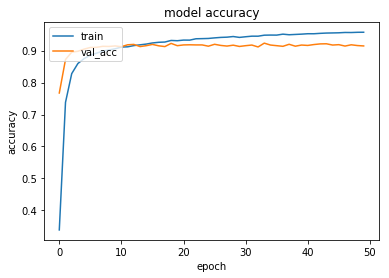

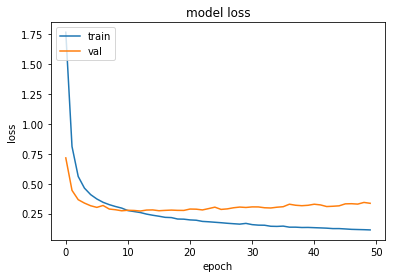

In [0]:
visualize(history)

In [0]:
model_json = model.to_json()
with open("/content/drive/My Drive/NLP/Model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/NLP/Model/model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# encoder = LabelEncoder()
# encoder.classes_ = numpy.load('classes.npy')
l = model.predict(np.array([tfidf_X_test_svd[1]]))

In [0]:
numpy.argmax(l[0])

0

In [0]:
y_test_one_hot[0]

0

In [0]:
y_test[0]

'Chinh tri Xa hoi'

'Chinh tri Xa hoi'

In [0]:
np.array([tfidf_X_test_svd[1]]).shape

(1, 500)

In [0]:
tfidf_X_test_svd.shape

(33759, 500)